# GBDT and Random Forest on Amzon fine food Review 

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

# Objective :-

Here we have to apply GBDT and Random forest classfication Alogoritm in various method for AMZON fine food review and check which 
method is very good.

1). Train,CV and test the data.

2). Here we are going to perform GridsearchCV for cossvalidation for finding best hyperparameters.

3). we will check the accuarcy and F1score for all the vectorization


In [1]:
import os
os.getcwd()

'C:\\Users\\Nicky\\Desktop\\my work\\GBDT and RF'

In [2]:
#Importing the nessary library for this assignement .
import numpy as np
import pandas as pd
import sqlite3 as sql
from time import time
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
#Peforemance measurment techniques
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm #for Instantly make your loops show a smart progress meter

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
#Functions to save objects for later use and retireve it
def export(obj,filename):
    pickle.dump(obj,open(filename+".dmp","wb"))
def import1(filename):
    temp = pickle.load(open(filename+".dmp","rb"))
    return temp

# Loading the cleaned data

In [4]:
#Using sqlite3 to retrieve data from sqlite file

con = sql.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
food1 = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
food1.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,positive,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...,b'june saw charm group rose begin droop pep ch...
1,150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


In [5]:
food1.groupby('Score').count()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText
Score,,,,,,,,,,,
negative,57107,57107,57107,57107,57107,57107,57107,57107,57107,57107,57107
positive,336824,336824,336824,336824,336824,336824,336824,336824,336824,336824,336824


In [6]:
def label(x):
    if x == "positive":
        return 1
    else:
        return 0
food1["Score"] = food1["Score"].map(label) #Map all the scores as the function polarity i.e. positive or negative

export(food1,'food1')

In [7]:
food1.groupby('Score').head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150528,150529,0006641040,A25ACLV5KPB4W,"Matt Hetling ""Matt""",0,1,1,1108425600,"Nice cadence, catchy rhymes",In June<br />I saw a charming group<br />of ro...,b'june saw charm group rose begin droop pep ch...
1,150506,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
10,150496,150497,0006641040,A1HKYQOFC8ZZCH,"Maria Apolloni ""lanarossa""",2,2,0,1334707200,"The story is great, the softcover book is disa...",I give five stars to the Maurice Sendak story....,b'give five star mauric sendak stori one star ...
22,150525,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,b'one best children book ever written mini ver...


In [8]:
food1_sample=food1.sample(n=20000) #Taking random sample from hole dataset
food1_sample.sort_values('Time',inplace=True)
food1_sample.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
899,149786,149787,B00004S1C6,A2XZKD83G4N9Y5,Cindy Elliott,43,45,1,1036454400,Great!,"For those wondering, the bottles are each 3/4 ...",b'wonder bottl gel food color vibrant amount g...
1186,149701,149702,B00006L2ZT,A25CKRB0P506KH,Jonathan P. Higgins,1,4,1,1036627200,Camper van Beethoven is the greatest rock band...,"Well, maybe not &quot;the&quot; greatest, but ...",b'well mayb not greatest one best set bring to...
440,374341,374342,B00004CI84,A10L8O1ZMUIMR2,G. Kleinschmidt,61,79,0,1040947200,Great movie turned bad,"Just to let you know, this movie is one of my ...",b'let know movi one person favorit ghost movi ...
362,374327,374328,B00004CI84,A1SWVKJIQWW33K,Rob Banzai,0,0,1,1053216000,"Freaky, silly, wry and creative","Ah, Tim Burton before he started taking himsel...",b'tim burton start take serious michael keaton...
1913,407456,407457,B000084F04,A1TZ2DO8CEOSQA,D. Fiol,6,6,1,1055635200,No good for automatic litter boxes,I have been trying various cat litters that ar...,b'tri various cat litter made thing clay cat l...


In [9]:
from sklearn.model_selection import TimeSeriesSplit
timesplit = TimeSeriesSplit(n_splits=2)

# Bag of Words (BoW)

The bag-of-words model is a simplifying representation used in natural language processing and information retrieval. In this model, a text is represented as the bag of its words, disregarding grammar and even word order but keeping multiplicity.

In [11]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(food1_sample['CleanedText'].values,food1_sample['Score'].values,test_size=0.3,shuffle=False)

#Text -> Uni gram Vectors
bi_gram = CountVectorizer(ngram_range=(1,2),min_df=10) 
X_train = bi_gram.fit_transform(X_train)
#normalize the data
X_train = preprocessing.normalize(X_train) #normalization of data has better accurac than mean centering and scalling
print("Train Data Size: ",X_train.shape)
X_test = bi_gram.transform(X_test)
#normalize the data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (14000, 8431)
Test Data Size:  (6000, 8431)


# GridSearchCV for Randomforest for finding best hyperparameter

In [28]:
alogo = RandomForestClassifier(class_weight='balanced')
#alogo = RandomForestClassifier()
#params we need to try on classifier
param_grid = {"n_estimators":list(range(9, 136, 9)),'max_depth':[2,5,10,16]} 
#param_grid={"n_estimators":[5,10,15]} 
gsv = GridSearchCV(alogo,param_grid,cv=timesplit,verbose=1,n_jobs=-1,scoring='f1_weighted')
gsv.fit(X_train,y_train)
export(gsv,"gsv_bigram")
print("Best HyperParameter: ",gsv.best_params_)
print("Best f1_weighted: %.2f%%"%(gsv.best_score_*100))

Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.7min finished


Best HyperParameter:  {'max_depth': 16, 'n_estimators': 135}
Best f1_weighted: 87.82%


Precision on Train data set: 0.970
Recall on Train data set: 0.915
F1-Score on Train data set: 0.941
Confusion Matrix of Train data set:
 [ [TN  FP]
 [FN TP] ]



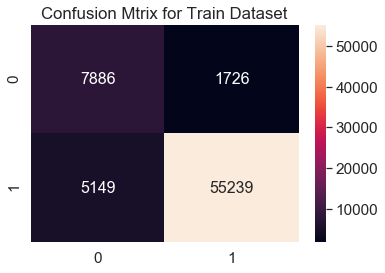

In [61]:
import seaborn as sns
alogo = gsv.best_estimator_
y_train_pred = alogo.predict(X_train)
print("Precision on Train data set: %0.3f"%(precision_score(y_train, y_train_pred)))
print("Recall on Train data set: %0.3f"%(recall_score(y_train, y_train_pred)))
print("F1-Score on Train data set: %0.3f"%(f1_score(y_train, y_train_pred)))
#print("Non Zero weights:",np.count_nonzero(alogo.coef_))
print("Confusion Matrix of Train data set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_train, y_train_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
plt.title("Confusion Mtrix for Train Dataset")
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

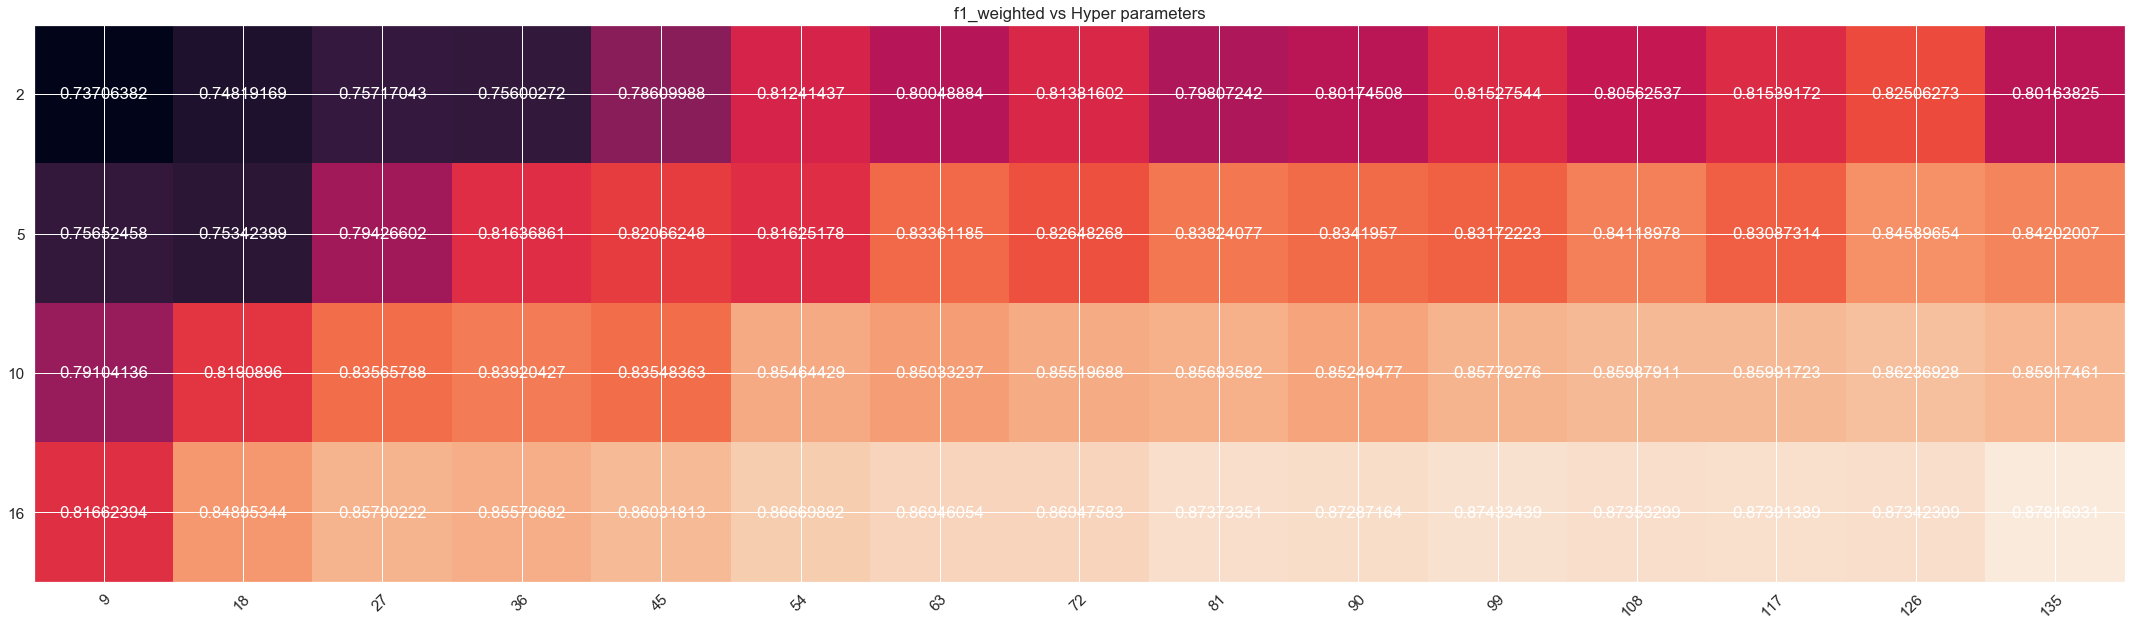

In [60]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

n_estimators=[9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99, 108, 117, 126, 135]
max_depth=[2,5,10,16]

score_dict = np.array([[0.73706382, 0.74819169, 0.75717043, 0.75600272, 0.78609988,0.81241437, 0.80048884, 0.81381602, 0.79807242, 0.80174508,
                       0.81527544, 0.80562537, 0.81539172, 0.82506273, 0.80163825],[0.75652458, 0.75342399, 0.79426602, 0.81636861, 0.82066248,
       0.81625178, 0.83361185, 0.82648268, 0.83824077, 0.8341957 ,0.83172223, 0.84118978, 0.83087314, 0.84589654, 0.84202007],[0.79104136, 0.8190896 , 0.83565788, 0.83920427, 0.83548363,
       0.85464429, 0.85033237, 0.85519688, 0.85693582, 0.85249477,0.85779276, 0.85987911, 0.85991723, 0.86236928, 0.85917461],[0.81662394, 0.84895344, 0.85790222, 0.85579682, 0.86031813,
       0.86669882, 0.86946054, 0.86947583, 0.87373351, 0.87287164,0.87433439, 0.87353299, 0.87391389, 0.87342309, 0.87816931]])

fig, ax = plt.subplots(figsize=(30,30))
im = ax.imshow(score_dict)

# We want to show all ticks...
ax.set_xticks(np.arange(len(n_estimators)))
ax.set_yticks(np.arange(len(max_depth)))
# ... and label them with the respective list entries
ax.set_xticklabels(n_estimators)
ax.set_yticklabels(max_depth)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(max_depth)):
    for j in range(len(n_estimators)):
        text = ax.text(j, i, score_dict[i, j],
                       ha="center", va="center", color="w")

ax.set_title("f1_weighted vs Hyper parameters")
fig.tight_layout()
plt.show()

In [30]:
gsv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=16, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=135, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Accuracy on test data set: 85.947%
Precision on test data set: 0.947
Recall on test data set: 0.882
F1-Score on test data set: 0.913
Confusion Matrix of test data set:
 [ [TN  FP]
 [FN TP] ]

Wall time: 1.58 s


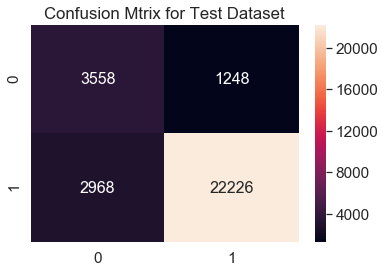

In [62]:
%%time
import seaborn as sns
alogo = gsv.best_estimator_
y_pred = alogo.predict(X_test)
print("Accuracy on test data set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test data set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test data set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test data set: %0.3f"%(f1_score(y_test, y_pred)))
#print("Non Zero weights:",np.count_nonzero(alogo.coef_))
print("Confusion Matrix of test data set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
plt.title("Confusion Mtrix for Test Dataset")
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

From the above confusion matirx we are getting 88% and 74% correctly classified point for both postive and negative class lable .

# Most Important Features in wordcloud for Random Forest

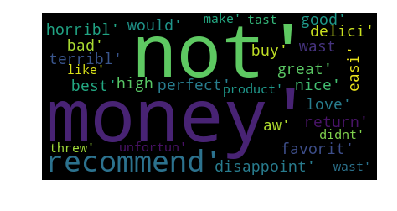

In [63]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
important_feature = alogo.feature_importances_
# Sort feature importances in descending order
indi = np.argsort(important_feature)[::-1][:30]
names = bi_gram.get_feature_names()
a=[]
for i in indi:
    a.append(names[i])
b=str(a).strip('[]')
wordcloud = WordCloud(relative_scaling = 1.0,
                     stopwords = set(STOPWORDS)
                      ).generate(b)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# GridSearchCV for Gradient Boosted Decision Trees

In [21]:
alogo = xgb.XGBClassifier(max_features='sqrt',min_samples_split=500,min_samples_leaf=50)
#params we need to try on classifier
param_grid = {'n_estimators':range(30,91,10), 
                  'max_depth':range(5,16,2), 
                  'learning_rate': list(np.arange(0.05,0.2,0.05))} 
gsv_gbdt = GridSearchCV(alogo,param_grid,cv=timesplit,verbose=1,n_jobs=-1,scoring='roc_auc')
#gsv = GridSearchCV(alogo,param_grid,cv=timesplit,verbose=1,n_jobs=-1,scoring='f1_weighted')
gsv_gbdt.fit(X_train,y_train)
#export(gsv,"gsv_bigram")
print("Best HyperParameter: ",gsv_gbdt.best_params_)
print("Best roc_auc: %.2f%%"%(gsv_gbdt.best_score_*100))

Fitting 2 folds for each of 168 candidates, totalling 336 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 336 out of 336 | elapsed: 26.7min finished


Best HyperParameter:  {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 90}
Best roc_auc: 87.76%


In [22]:
gsv_gbdt.cv_results_['mean_test_score']

array([0.79156608, 0.80116797, 0.81245171, 0.82369761, 0.8318979 ,
       0.83822936, 0.84313174, 0.79850422, 0.81124877, 0.82014068,
       0.828858  , 0.83712199, 0.84346252, 0.8484284 , 0.80454755,
       0.81938752, 0.82629766, 0.83338044, 0.84078609, 0.84712981,
       0.85221074, 0.81015724, 0.82525723, 0.83148849, 0.83808642,
       0.84479894, 0.84966348, 0.85420129, 0.81371666, 0.82708948,
       0.83373374, 0.8383171 , 0.84579929, 0.85057074, 0.85482284,
       0.81670045, 0.82982133, 0.83599077, 0.84120549, 0.84671324,
       0.85120899, 0.8552523 , 0.81947056, 0.83669539, 0.84703053,
       0.8560443 , 0.85995928, 0.8655708 , 0.86855225, 0.82723074,
       0.84103196, 0.84901974, 0.8559309 , 0.86332695, 0.8657107 ,
       0.86850719, 0.83202476, 0.84514351, 0.85476911, 0.860883  ,
       0.8648917 , 0.86805334, 0.87015738, 0.83746621, 0.84947609,
       0.85759762, 0.86356777, 0.86706823, 0.86953438, 0.87174311,
       0.83824836, 0.84983577, 0.85725758, 0.8619943 , 0.86543

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


f1_weighted on test data set: 88.083%
Precision on test data set: 0.890
Recall on test data set: 0.979
F1-Score on test data set: 0.932
Confusion Matrix of test data set:
 [ [TN  FP]
 [FN TP] ]

Wall time: 179 ms


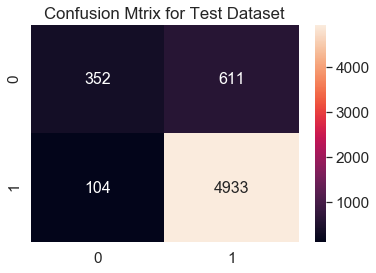

In [24]:
%%time
import seaborn as sns
alogo = gsv_gbdt.best_estimator_
y_pred = alogo.predict(X_test)
print("f1_weighted on test data set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test data set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test data set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test data set: %0.3f"%(f1_score(y_test, y_pred)))
#print("Non Zero weights:",np.count_nonzero(alogo.coef_))
print("Confusion Matrix of test data set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
plt.title("Confusion Mtrix for Test Dataset")
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

From the above confusion matirx we are getting 98% and 44% correctly classified point for both postive and negative class lable repectivly  

# Feature Importance :-

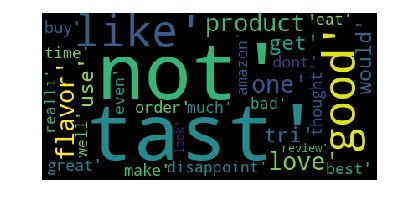

In [25]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
important_feature = alogo.feature_importances_
# Sort feature importances in descending order
indi = np.argsort(important_feature)[::-1][:30]
names = bi_gram.get_feature_names()
a=[]
for i in indi:
    a.append(names[i])
b=str(a).strip('[]')
wordcloud = WordCloud(relative_scaling = 1.0,
                     stopwords = set(STOPWORDS)
                      ).generate(b)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# TF-IDF

In [26]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(food1_sample['CleanedText'].values,food1_sample['Score'].values,test_size=0.3,shuffle=False)

tfidf_vec = TfidfVectorizer(ngram_range=(1,2),min_df=20) #Using bi-grams
X_train = tfidf_vec.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf_vec.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (21000, 5951)
Test Data Size:  (9000, 5951)
Wall time: 4.61 s


# GridSearchCV for Randomforest for finding best hyperparameter

In [24]:
alogo = RandomForestClassifier(class_weight='balanced')
#alogo = RandomForestClassifier()
#params we need to try on classifier
param_grid = {"n_estimators":list(range(9, 136, 9)),'max_depth':[2,5,10,16]} 
#param_grid={"n_estimators":[5,10,15]} 
gsv = GridSearchCV(alogo,param_grid,cv=timesplit,verbose=1,n_jobs=-1,scoring='f1_weighted')
#params we need to try on classifier
#param_grid = param_grid = {"n_estimators":[int(i) for i in range(30, 170, 20)]}  
#gsv = GridSearchCV(alogo,param_grid,cv=timesplit,verbose=1,n_jobs=-1)
gsv.fit(X_train,y_train)
#export(gsv,"gsv_bigram")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  9.3min finished


Best HyperParameter:  {'max_depth': 16, 'n_estimators': 135}
Best Accuracy: 88.09%


Precision on Train data set: 0.970
Recall on Train data set: 0.918
F1-Score on Train data set: 0.943
Confusion Matrix of Train data set:
 [ [TN  FP]
 [FN TP] ]



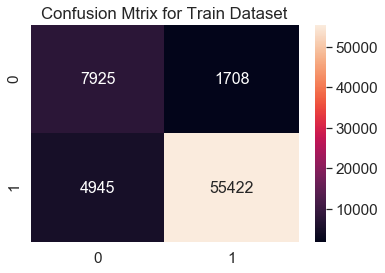

In [27]:
import seaborn as sns
alogo = gsv.best_estimator_
y_train_pred = alogo.predict(X_train)
print("Precision on Train data set: %0.3f"%(precision_score(y_train, y_train_pred)))
print("Recall on Train data set: %0.3f"%(recall_score(y_train, y_train_pred)))
print("F1-Score on Train data set: %0.3f"%(f1_score(y_train, y_train_pred)))
#print("Non Zero weights:",np.count_nonzero(alogo.coef_))
print("Confusion Matrix of Train data set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_train, y_train_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
plt.title("Confusion Mtrix for Train Dataset")
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [25]:
gsv_gbdt.cv_results_['mean_test_score']

array([0.75777627, 0.70453081, 0.71722497, 0.74831398, 0.78748724,
       0.78701506, 0.80611149, 0.79718532, 0.80809586, 0.78722316,
       0.82522243, 0.81507966, 0.81965998, 0.80958361, 0.81540235,
       0.76037138, 0.79482329, 0.81184274, 0.81343726, 0.81658945,
       0.818938  , 0.82447129, 0.82271794, 0.83094111, 0.84668821,
       0.83447693, 0.83469501, 0.84243186, 0.84040171, 0.84575287,
       0.78668502, 0.82067446, 0.82668221, 0.8395481 , 0.84800006,
       0.85309547, 0.8508645 , 0.85852908, 0.85551119, 0.85917384,
       0.86096672, 0.85956193, 0.86304641, 0.8608328 , 0.86123498,
       0.81232726, 0.83867965, 0.85167648, 0.86048048, 0.86681721,
       0.86574772, 0.87022551, 0.87110255, 0.86983885, 0.87712008,
       0.87611895, 0.87525551, 0.87752044, 0.87780615, 0.88086091])

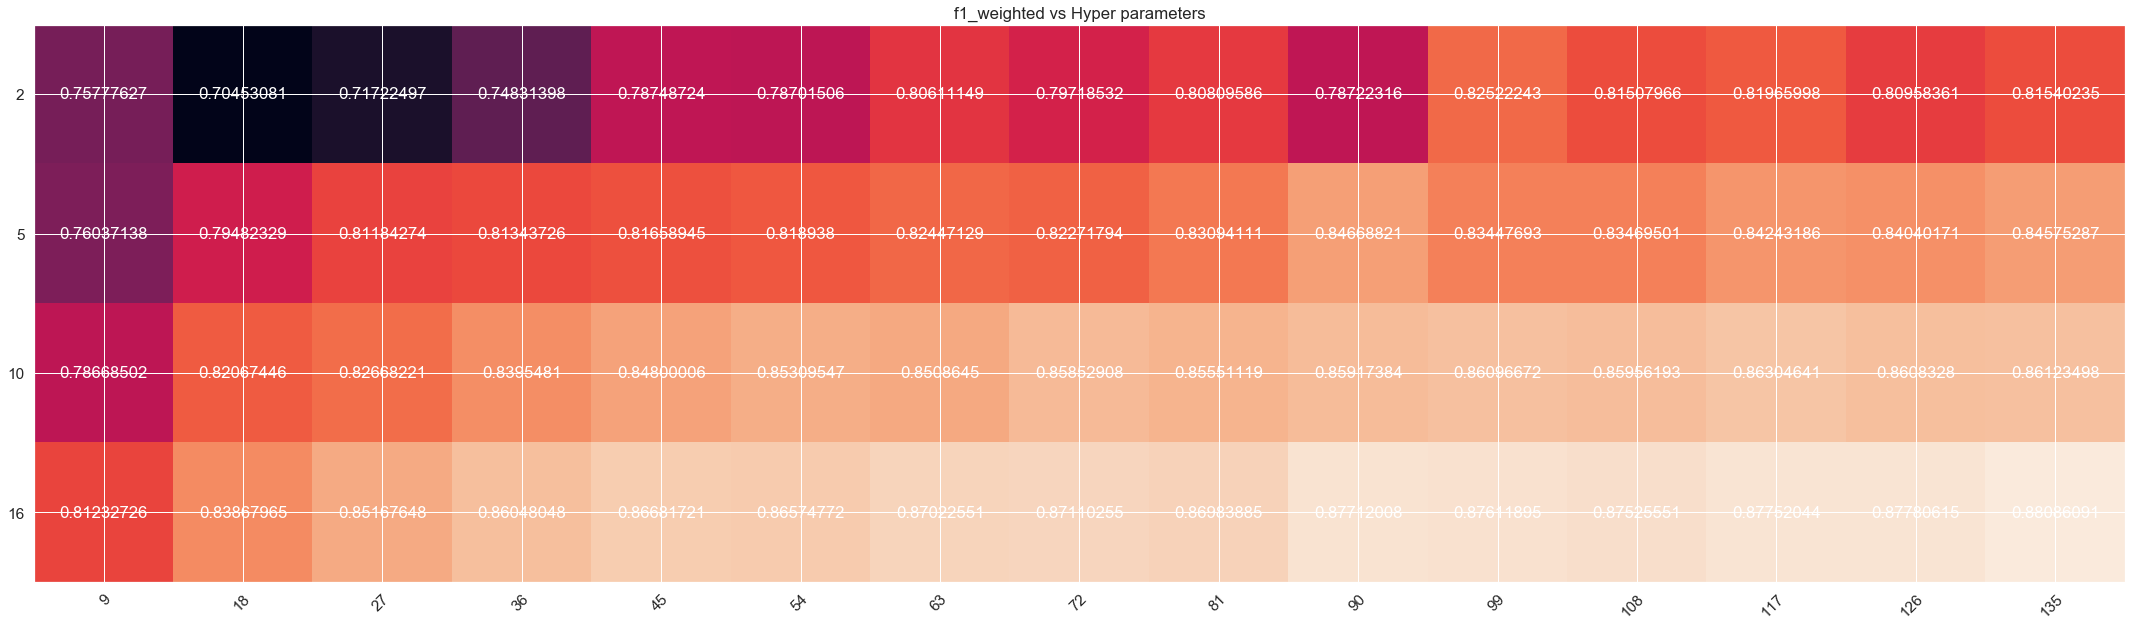

In [26]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

n_estimators=[9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99, 108, 117, 126, 135]
max_depth=[2,5,10,16]

score_dict = np.array([[0.75777627, 0.70453081, 0.71722497, 0.74831398, 0.78748724,
       0.78701506, 0.80611149, 0.79718532, 0.80809586, 0.78722316,
       0.82522243, 0.81507966, 0.81965998, 0.80958361, 0.81540235],
       [0.76037138, 0.79482329, 0.81184274, 0.81343726, 0.81658945,
       0.818938  , 0.82447129, 0.82271794, 0.83094111, 0.84668821,
       0.83447693, 0.83469501, 0.84243186, 0.84040171, 0.84575287],
       [0.78668502, 0.82067446, 0.82668221, 0.8395481 , 0.84800006,
       0.85309547, 0.8508645 , 0.85852908, 0.85551119, 0.85917384,
       0.86096672, 0.85956193, 0.86304641, 0.8608328 , 0.86123498],
       [0.81232726, 0.83867965, 0.85167648, 0.86048048, 0.86681721,
       0.86574772, 0.87022551, 0.87110255, 0.86983885, 0.87712008,
       0.87611895, 0.87525551, 0.87752044, 0.87780615, 0.88086091]])

fig, ax = plt.subplots(figsize=(30,30))
im = ax.imshow(score_dict)

# We want to show all ticks...
ax.set_xticks(np.arange(len(n_estimators)))
ax.set_yticks(np.arange(len(max_depth)))
# ... and label them with the respective list entries
ax.set_xticklabels(n_estimators)
ax.set_yticklabels(max_depth)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(max_depth)):
    for j in range(len(n_estimators)):
        text = ax.text(j, i, score_dict[i, j],
                       ha="center", va="center", color="w")

ax.set_title("f1_weighted vs Hyper parameters")
fig.tight_layout()
plt.show()

Accuracy on test data set: 86.197%
Precision on test data set: 0.949
Recall on test data set: 0.883
F1-Score on test data set: 0.915
Confusion Matrix of test data set:
 [ [TN  FP]
 [FN TP] ]

Wall time: 1.64 s


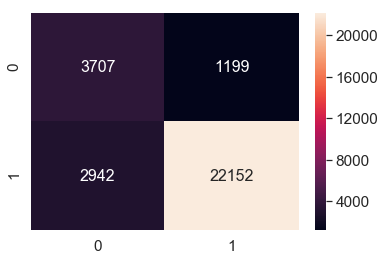

In [28]:
%%time
import seaborn as sns
alogo = gsv.best_estimator_
y_pred = alogo.predict(X_test)
print("Accuracy on test data set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test data set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test data set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test data set: %0.3f"%(f1_score(y_test, y_pred)))
#print("Non Zero weights:",np.count_nonzero(alogo.coef_))
print("Confusion Matrix of test data set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

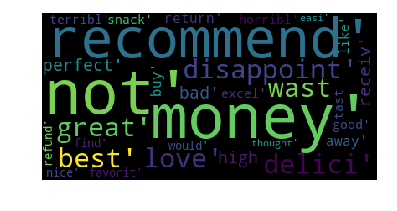

In [29]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
important_feature = alogo.feature_importances_
# Sort feature importances in descending order
indi = np.argsort(important_feature)[::-1][:30]
names = bi_gram.get_feature_names()
a=[]
for i in indi:
    a.append(names[i])
b=str(a).strip('[]')
wordcloud = WordCloud(relative_scaling = 1.0,
                     stopwords = set(STOPWORDS)
                      ).generate(b)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# GridSearchCV for Gradient Boosted Decision Trees

In [27]:
alogo = xgb.XGBClassifier(class_weight='balanced',min_samples_split=300,min_samples_leaf=30)
#params we need to try on classifier
param_grid = {'n_estimators':range(50,121,10),'learning_rate': list(np.arange(0.05,0.2,0.05)),'max_depth':range(5,16,2)} 
gsv_gbdt = GridSearchCV(alogo,param_grid,cv=timesplit,verbose=1,n_jobs=-1,scoring='f1_weighted')
#gsv = GridSearchCV(alogo,param_grid,cv=timesplit,verbose=1,n_jobs=-1,scoring='f1_weighted')
gsv_gbdt.fit(X_train,y_train)
#export(gsv,"gsv_bigram")
print("Best HyperParameter: ",gsv_gbdt.best_params_)
print("Best roc_auc: %.2f%%"%(gsv_gbdt.best_score_*100))

Fitting 2 folds for each of 192 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed: 62.9min finished


Best HyperParameter:  {'learning_rate': 0.2, 'max_depth': 11, 'n_estimators': 110}
Best roc_auc: 86.91%


In [28]:
gsv_gbdt.cv_results_['mean_test_score']

array([0.81263058, 0.81415329, 0.81662155, 0.81947387, 0.82241637,
       0.82433113, 0.82729758, 0.82974055, 0.82227072, 0.8255658 ,
       0.82806986, 0.83014287, 0.83232638, 0.83458052, 0.83668457,
       0.83970186, 0.83087942, 0.83213854, 0.83444146, 0.83751493,
       0.83904095, 0.84072763, 0.84211249, 0.84380246, 0.83428274,
       0.83593538, 0.83788092, 0.84087066, 0.84244333, 0.84493142,
       0.84648735, 0.84793128, 0.83763183, 0.83947558, 0.8427725 ,
       0.84452012, 0.84551454, 0.84703359, 0.84877862, 0.84972877,
       0.83983724, 0.8419024 , 0.84373638, 0.84594119, 0.84754845,
       0.84963981, 0.8501326 , 0.85098068, 0.82610226, 0.83085619,
       0.83651801, 0.83963762, 0.84286615, 0.84649558, 0.84864126,
       0.85083838, 0.83657323, 0.84237634, 0.84633893, 0.8490539 ,
       0.85169545, 0.85323222, 0.85637351, 0.85701084, 0.84048906,
       0.84389643, 0.84714627, 0.85070152, 0.85404971, 0.8559445 ,
       0.85710134, 0.85767029, 0.84380246, 0.84837522, 0.85186

Accuracy on test data set: 89.111%
Precision on test data set: 0.899
Recall on test data set: 0.980
F1-Score on test data set: 0.938
Confusion Matrix of test data set:
 [ [TN  FP]
 [FN TP] ]

Wall time: 293 ms


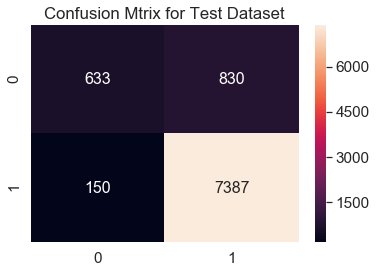

In [30]:
%%time
import seaborn as sns
alogo = gsv_gbdt.best_estimator_
y_pred = alogo.predict(X_test)
print("Accuracy on test data set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test data set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test data set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test data set: %0.3f"%(f1_score(y_test, y_pred)))
#print("Non Zero weights:",np.count_nonzero(alogo.coef_))
print("Confusion Matrix of test data set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
plt.title("Confusion Mtrix for Test Dataset")
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

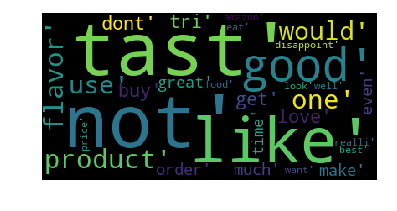

In [40]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
important_feature = alogo.feature_importances_
# Sort feature importances in descending order
indi = np.argsort(important_feature)[::-1][:30]
names = tfidf_vec.get_feature_names()
a=[]
for i in indi:
    a.append(names[i])
b=str(a).strip('[]')
wordcloud = WordCloud(relative_scaling = 1.0,
                     stopwords = set(STOPWORDS)
                      ).generate(b)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Clean the text with no stem for avgw2v and tfidf-w2v model

In [27]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
stop.remove('not')
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'into', 'all', 'other', 'him', 'itself', 'these', "shouldn't", 'than', 'did', "weren't", "mustn't", 're', "wouldn't", 'what', 'such', 'against', 'in', 'll', 'they', 'ours', 'have', 'ain', 'the', 'from', 'through', 'and', 'why', 'she', 'does', "won't", 'yourself', 'now', 'out', 'where', "mightn't", 'mightn', "she's", 'between', 'over', 'doing', 'ourselves', 'during', 'because', 'yours', 'having', 'then', 'himself', "hasn't", 'her', 'haven', 'mustn', 'an', 'same', 'this', 'as', 'won', 'm', 'themselves', 'most', 'by', 'own', 'aren', "it's", 'his', 'd', "hadn't", 'it', 'how', 'if', 'me', "needn't", 'them', 'has', 'can', "you'd", 'that', 'weren', 'am', 'a', 'when', 'who', 'our', 'their', 'we', 'there', 'do', 'o', 'y', 'whom', 'had', 'after', 'further', 'been', 'any', 'didn', 'few', 'too', "didn't", "you'll", 'is', 'but', 'my', "couldn't", 'shan', 'off', 'are', 'while', 'couldn', 'its', 'will', 'he', 'being', 'i', 't', 'hers', "wasn't", 'very', 'you', 'be', 've', 'with', 'to', 'only', "shou

# Spliting the train and test data before running any model

In [25]:
X_train, X_test, y_train, y_test = train_test_split(food1_sample['Text'].values,food1_sample['Score'].values,test_size=0.3,shuffle=False)

In [28]:
i=0
train_list_of_sent=[]
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    train_list_of_sent.append(filtered_sentence)

In [29]:
i=0
Test_list_of_sent=[]
for sent in X_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    Test_list_of_sent.append(filtered_sentence)

# w2v model

In [30]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

D:\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Avg w2v model

In [31]:
%%time
#np.seterr(divide='ignore', invalid='ignore')
# average Word2Vec
# compute average word2vec for each review.
train_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(train_list_of_sent): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    train_sent_vectors.append(sent_vec)
print(len(train_sent_vectors))
print(len(train_sent_vectors[0]))
export(train_sent_vectors,'train_sent_vectors')

100%|███████████████████████████████████| 14000/14000 [00:14<00:00, 969.68it/s]


14000
300
Wall time: 14.8 s


In [32]:
train_sent_vectors = np.array(train_sent_vectors)

In [33]:
np.isnan(train_sent_vectors).any()

False

In [34]:
%%time
#np.seterr(divide='ignore', invalid='ignore')
# average Word2Vec
# compute average word2vec for each review.
Test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(Test_list_of_sent): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    Test_sent_vectors.append(sent_vec)
print(len(Test_sent_vectors))
print(len(Test_sent_vectors[0]))
export(Test_sent_vectors,'Test_sent_vectors')

100%|█████████████████████████████████████| 6000/6000 [00:06<00:00, 946.47it/s]


6000
300
Wall time: 6.43 s


In [35]:
from sklearn.preprocessing import Imputer
mean_imputer = Imputer(missing_values='NaN', strategy='median')
Test_sent_vectors = mean_imputer.fit_transform(Test_sent_vectors)

In [36]:
Test_sent_vectors = np.array(Test_sent_vectors)

In [37]:
np.isnan(Test_sent_vectors).any()

False

# GridSearchCV for Randomforest for finding best hyperparameter

In [62]:
#alogo = RandomForestClassifier(class_weight='balanced')
#alogo = RandomForestClassifier()
#params we need to try on classifier
#param_grid = {"n_estimators":[int(i) for i in range(10, 150, 20)]} 
#param_grid={"n_estimators":[5,10,15]} 
#gsv = GridSearchCV(alogo,param_grid,cv=timesplit,verbose=1,n_jobs=-1,scoring='f1')
#gsv = GridSearchCV(alogo,param_grid,cv=timesplit,verbose=1,n_jobs=-1,scoring='f1_micro')
alogo = RandomForestClassifier(class_weight='balanced')
#alogo = RandomForestClassifier()
#params we need to try on classifier
param_grid = {"n_estimators":list(range(9, 136, 9)),'max_depth':[2,5,10,16]} 
#param_grid={"n_estimators":[5,10,15]} 
gsv = GridSearchCV(alogo,param_grid,cv=timesplit,verbose=1,n_jobs=-1,scoring='f1_weighted')
#alogo = RandomForestClassifier()
#params we need to try on classifier
#param_grid = param_grid = {"n_estimators":[int(i) for i in range(30, 170, 20)]}  
#gsv = GridSearchCV(alogo,param_grid,cv=timesplit,verbose=1,n_jobs=-1)
gsv.fit(train_sent_vectors,y_train)
#export(gsv,"gsv_bigram")
print("Best HyperParameter: ",gsv.best_params_)
print("Best f1_weighted: %.2f%%"%(gsv.best_score_*100))

Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 35.7min finished


Best HyperParameter:  {'max_depth': 10, 'n_estimators': 135}
Best f1_weighted: 84.49%


Precision on Train data set: 0.984
Recall on Train data set: 0.914
F1-Score on Train data set: 0.948
Confusion Matrix of Train data set:
 [ [TN  FP]
 [FN TP] ]



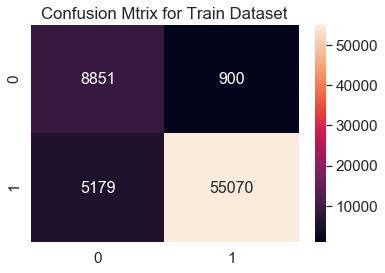

In [65]:
import seaborn as sns
alogo = gsv.best_estimator_
y_train_pred = alogo.predict(train_sent_vectors)
print("Precision on Train data set: %0.3f"%(precision_score(y_train, y_train_pred)))
print("Recall on Train data set: %0.3f"%(recall_score(y_train, y_train_pred)))
print("F1-Score on Train data set: %0.3f"%(f1_score(y_train, y_train_pred)))
#print("Non Zero weights:",np.count_nonzero(alogo.coef_))
print("Confusion Matrix of Train data set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_train, y_train_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
plt.title("Confusion Mtrix for Train Dataset")
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Accuracy on test data set: 82.977%
Precision on test data set: 0.919
Recall on test data set: 0.874
F1-Score on test data set: 0.896
Confusion Matrix of test data set:
 [ [TN  FP]
 [FN TP] ]

Wall time: 1.64 s


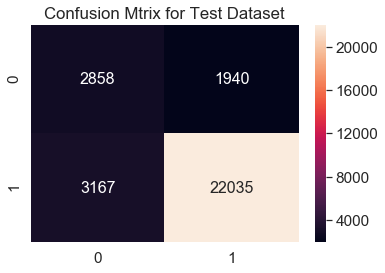

In [66]:
%%time
import seaborn as sns
alogo = gsv.best_estimator_
y_pred = alogo.predict(Test_sent_vectors)
print("Accuracy on test data set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test data set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test data set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test data set: %0.3f"%(f1_score(y_test, y_pred)))
#print("Non Zero weights:",np.count_nonzero(alogo.coef_))
print("Confusion Matrix of test data set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
plt.title("Confusion Mtrix for Test Dataset")
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [67]:
gsv.cv_results_['mean_test_score']

array([0.68857895, 0.71062648, 0.71557763, 0.72673114, 0.72752138,
       0.72432173, 0.7270995 , 0.72864414, 0.72375767, 0.72913984,
       0.72281383, 0.72485699, 0.72243395, 0.72783322, 0.73078643,
       0.75093866, 0.76204355, 0.76353563, 0.76567983, 0.76913226,
       0.76988747, 0.76893434, 0.76849258, 0.7720221 , 0.77027378,
       0.76962589, 0.7706276 , 0.77214999, 0.77071773, 0.77007382,
       0.82385659, 0.83579475, 0.83885997, 0.84120685, 0.84234502,
       0.8408537 , 0.84266921, 0.84299048, 0.8444157 , 0.84392968,
       0.84443432, 0.84401014, 0.84463003, 0.84461333, 0.84493579,
       0.82413575, 0.82726109, 0.82543691, 0.82469474, 0.82370111,
       0.8260496 , 0.82423336, 0.82478493, 0.82510287, 0.82400981,
       0.8242094 , 0.82458291, 0.82335916, 0.82444376, 0.82456236])

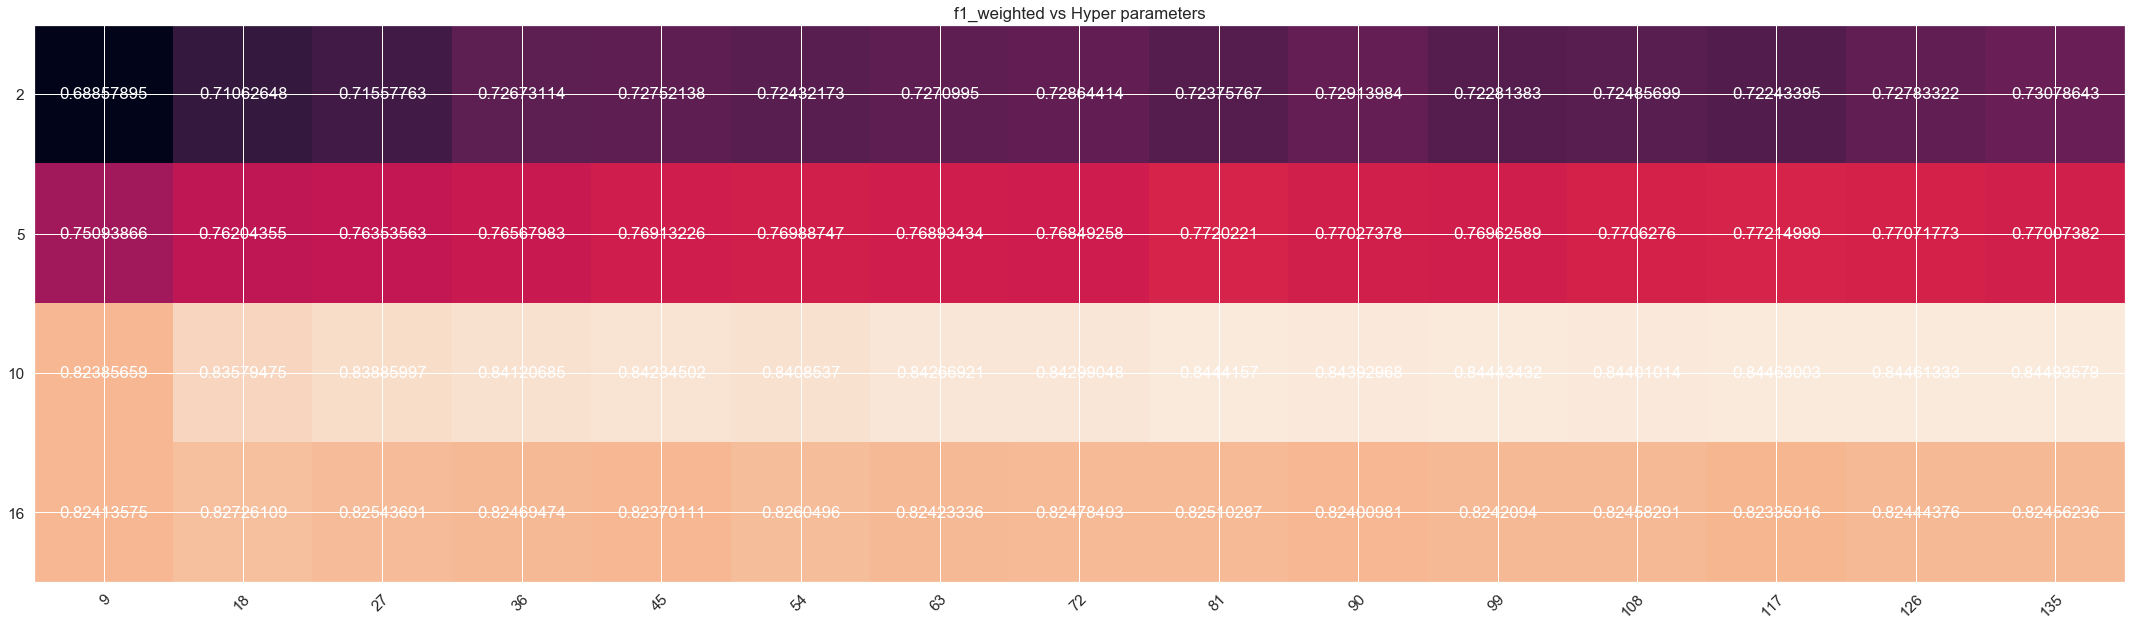

In [68]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

n_estimators=list(range(9, 136, 9))
max_depth=[2,5,10,16]

score_dict = np.array([[0.68857895, 0.71062648, 0.71557763, 0.72673114, 0.72752138,
       0.72432173, 0.7270995 , 0.72864414, 0.72375767, 0.72913984,
       0.72281383, 0.72485699, 0.72243395, 0.72783322, 0.73078643],
       [0.75093866, 0.76204355, 0.76353563, 0.76567983, 0.76913226,
       0.76988747, 0.76893434, 0.76849258, 0.7720221 , 0.77027378,
       0.76962589, 0.7706276 , 0.77214999, 0.77071773, 0.77007382],
       [0.82385659, 0.83579475, 0.83885997, 0.84120685, 0.84234502,
       0.8408537 , 0.84266921, 0.84299048, 0.8444157 , 0.84392968,
       0.84443432, 0.84401014, 0.84463003, 0.84461333, 0.84493579],
       [0.82413575, 0.82726109, 0.82543691, 0.82469474, 0.82370111,
       0.8260496 , 0.82423336, 0.82478493, 0.82510287, 0.82400981,
       0.8242094 , 0.82458291, 0.82335916, 0.82444376, 0.82456236]])

fig, ax = plt.subplots(figsize=(30,30))
im = ax.imshow(score_dict)

# We want to show all ticks...
ax.set_xticks(np.arange(len(n_estimators)))
ax.set_yticks(np.arange(len(max_depth)))
# ... and label them with the respective list entries
ax.set_xticklabels(n_estimators)
ax.set_yticklabels(max_depth)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(max_depth)):
    for j in range(len(n_estimators)):
        text = ax.text(j, i, score_dict[i, j],
                       ha="center", va="center", color="w")

ax.set_title("f1_weighted vs Hyper parameters")
fig.tight_layout()
plt.show()

# GridSearchCV for Gradient Boosted Decision Trees

In [38]:
alogo = xgb.XGBClassifier(class_weight='balanced',min_samples_split=300,min_samples_leaf=30)
#params we need to try on classifier
param_grid = {'n_estimators':range(50,121,10),'learning_rate': list(np.arange(0.05,0.2,0.05)),'max_depth':range(5,16,2)} 
gsv_gbdt = GridSearchCV(alogo,param_grid,cv=timesplit,verbose=1,n_jobs=-1,scoring='f1_weighted')
#alogo = xgb.XGBClassifier(class_weight="balanced")
#params we need to try on classifier
#param_grid = {'max_depth':[2,5,10,16],"n_estimators":[int(i) for i in range(10, 150, 20)]} 
#gsv_gbdt = GridSearchCV(alogo,param_grid,cv=timesplit,verbose=1,n_jobs=-1,scoring='f1')
gsv_gbdt.fit(train_sent_vectors,y_train)
print("Best HyperParameter: ",gsv_gbdt.best_params_)
print("Best f1_weighted: %.2f%%"%(gsv_gbdt.best_score_*100))

Fitting 2 folds for each of 192 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 75.1min
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed: 142.7min finished


Best HyperParameter:  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 110}
Best f1_weighted: 84.37%


In [40]:
gsv_gbdt.cv_results_["mean_test_score"]

array([0.79914478, 0.80184548, 0.80714544, 0.81202869, 0.81536723,
       0.81994459, 0.82318916, 0.82406733, 0.80774831, 0.81047512,
       0.8135182 , 0.81674102, 0.81927208, 0.82122459, 0.82462892,
       0.8249331 , 0.80926423, 0.80998779, 0.81150029, 0.8119934 ,
       0.81319458, 0.81399523, 0.81619279, 0.81774297, 0.80536193,
       0.80514064, 0.80569625, 0.80878788, 0.80992374, 0.81193459,
       0.8117356 , 0.81371306, 0.80744181, 0.80662649, 0.80870984,
       0.80883841, 0.81076134, 0.81221688, 0.81235055, 0.81367699,
       0.8051927 , 0.80532494, 0.80627058, 0.80763988, 0.80835217,
       0.80939379, 0.81095567, 0.81239127, 0.81894471, 0.82712617,
       0.82817469, 0.82997231, 0.8299312 , 0.83153777, 0.83445417,
       0.83473261, 0.82246709, 0.82331757, 0.82689007, 0.82729182,
       0.82783901, 0.83042868, 0.82995104, 0.83104954, 0.81684591,
       0.81799041, 0.82060911, 0.82082873, 0.82125674, 0.82355682,
       0.824845  , 0.8246075 , 0.81227306, 0.81394905, 0.81547

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy on test data set: 87.567%
Precision on test data set: 0.888
Recall on test data set: 0.975
F1-Score on test data set: 0.929
Confusion Matrix of test data set:
 [ [TN  FP]
 [FN TP] ]

Wall time: 172 ms


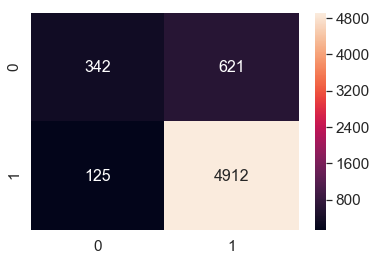

In [39]:
%%time
import seaborn as sns
alogo = gsv_gbdt.best_estimator_
y_pred = alogo.predict(Test_sent_vectors)
print("Accuracy on test data set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test data set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test data set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test data set: %0.3f"%(f1_score(y_test, y_pred)))
#print("Non Zero weights:",np.count_nonzero(alogo.coef_))
print("Confusion Matrix of test data set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# TFIDF-W2V

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
tfidf = TfidfVectorizer(ngram_range=(1,1),min_df=20) #Using bi-grams
tfidf_vec = tfidf.fit_transform(X_train)

In [42]:
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))

In [43]:
%%time
# TF-IDF weighted Word2Vec
# tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(train_list_of_sent): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = model.wv[word]
            #print(vec)
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*sent.count(word)
            #print()
            sent_vec += (vec * tf_idf)
            #print(sent_vec)
            #print(tfidf)
            #print(sent_vec)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    train_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████| 14000/14000 [00:22<00:00, 618.59it/s]


Wall time: 22.6 s


In [44]:
train_tfidf_sent_vectors = np.array(train_tfidf_sent_vectors)

In [45]:
from sklearn.preprocessing import Imputer
mean_imputer = Imputer(missing_values='NaN', strategy='median')
train_tfidf_sent_vectors = mean_imputer.fit_transform(train_tfidf_sent_vectors)

In [46]:
np.isnan(train_sent_vectors).any()

False

In [47]:
%%time
# TF-IDF weighted Word2Vec
# tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(Test_list_of_sent): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = model.wv[word]
            #print(vec)
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = dictionary[word]*sent.count(word)
            #print()
            sent_vec += (vec * tf_idf)
            #print(sent_vec)
            #print(tfidf)
            #print(sent_vec)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    test_tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████| 6000/6000 [00:09<00:00, 607.07it/s]


Wall time: 9.89 s


In [48]:
test_tfidf_sent_vectors = np.array(test_tfidf_sent_vectors)

In [49]:
from sklearn.preprocessing import Imputer
mean_imputer = Imputer(missing_values='NaN', strategy='median')
test_tfidf_sent_vectors = mean_imputer.fit_transform(test_tfidf_sent_vectors)

# GridSearchCV for Randomforest for finding best hyperparameter

In [38]:
alogo = RandomForestClassifier(class_weight='balanced')
#alogo = RandomForestClassifier()
#params we need to try on classifier
param_grid = {"n_estimators":list(range(9, 136, 9)),'max_depth':[2,5,10,16]} 
#param_grid={"n_estimators":[5,10,15]} 
gsv = GridSearchCV(alogo,param_grid,cv=timesplit,verbose=1,n_jobs=-1,scoring='f1_weighted')
#alogo = RandomForestClassifier(class_weight='balanced')
#alogo = RandomForestClassifier()
#params we need to try on classifier
#param_grid = {"n_estimators":[int(i) for i in range(10, 150, 20)]} 
#param_grid={"n_estimators":[5,10,15]} 
#gsv = GridSearchCV(alogo,param_grid,cv=timesplit,verbose=1,n_jobs=-1,scoring='f1')
#gsv = GridSearchCV(alogo,param_grid,cv=timesplit,verbose=1,n_jobs=-1,scoring='f1_micro')
#alogo = RandomForestClassifier()
#params we need to try on classifier
#param_grid = param_grid = {"n_estimators":[int(i) for i in range(30, 170, 20)]}  
#gsv = GridSearchCV(alogo,param_grid,cv=timesplit,verbose=1,n_jobs=-1)
gsv.fit(train_tfidf_sent_vectors,y_train)
#export(gsv,"gsv_bigram")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.7min finished


Best HyperParameter:  {'max_depth': 5, 'n_estimators': 72}
Best Accuracy: 82.16%


Precision on Train data set: 0.955
Recall on Train data set: 0.839
F1-Score on Train data set: 0.893
Confusion Matrix of Train data set:
 [ [TN  FP]
 [FN TP] ]



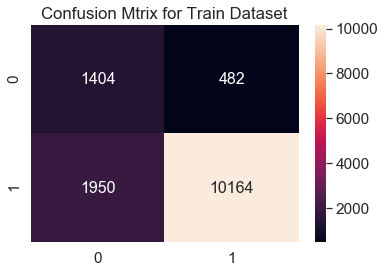

In [40]:
import seaborn as sns
alogo = gsv.best_estimator_
y_train_pred = alogo.predict(train_tfidf_sent_vectors)
print("Precision on Train data set: %0.3f"%(precision_score(y_train, y_train_pred)))
print("Recall on Train data set: %0.3f"%(recall_score(y_train, y_train_pred)))
print("F1-Score on Train data set: %0.3f"%(f1_score(y_train, y_train_pred)))
#print("Non Zero weights:",np.count_nonzero(alogo.coef_))
print("Confusion Matrix of Train data set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_train, y_train_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
plt.title("Confusion Mtrix for Train Dataset")
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

Accuracy on test data set: 76.983%
Precision on test data set: 0.913
Recall on test data set: 0.802
F1-Score on test data set: 0.854
Confusion Matrix of test data set:
 [ [TN  FP]
 [FN TP] ]

Wall time: 166 ms


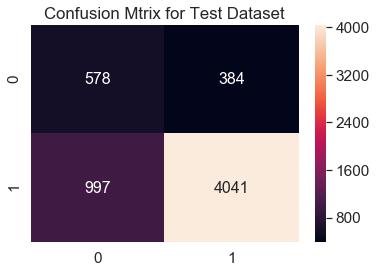

In [41]:
%%time
import seaborn as sns
alogo = gsv.best_estimator_
y_pred = alogo.predict(test_tfidf_sent_vectors)
print("Accuracy on test data set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test data set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test data set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test data set: %0.3f"%(f1_score(y_test, y_pred)))
#print("Non Zero weights:",np.count_nonzero(alogo.coef_))
print("Confusion Matrix of test data set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
plt.title("Confusion Mtrix for Test Dataset")
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [42]:
gsv.cv_results_["mean_test_score"]

array([0.7117006 , 0.72735877, 0.73331947, 0.74459943, 0.75001463,
       0.76289243, 0.75162327, 0.75902647, 0.75743012, 0.75465767,
       0.76164841, 0.75370252, 0.75304406, 0.75668558, 0.75102582,
       0.77532674, 0.79971117, 0.80485717, 0.81288226, 0.81702731,
       0.8116985 , 0.81039545, 0.82161131, 0.81572105, 0.81701868,
       0.81715487, 0.81641747, 0.81939432, 0.81949071, 0.81821046,
       0.81864313, 0.82079917, 0.81811469, 0.81845701, 0.81941702,
       0.81836521, 0.81734202, 0.81898717, 0.81600371, 0.81565816,
       0.81780267, 0.8177797 , 0.81732951, 0.81829755, 0.81913847,
       0.81101265, 0.80252024, 0.80408756, 0.80343971, 0.80094136,
       0.80128325, 0.80104554, 0.79910787, 0.79993904, 0.79843713,
       0.80005727, 0.79801786, 0.80007265, 0.80069853, 0.80023306])

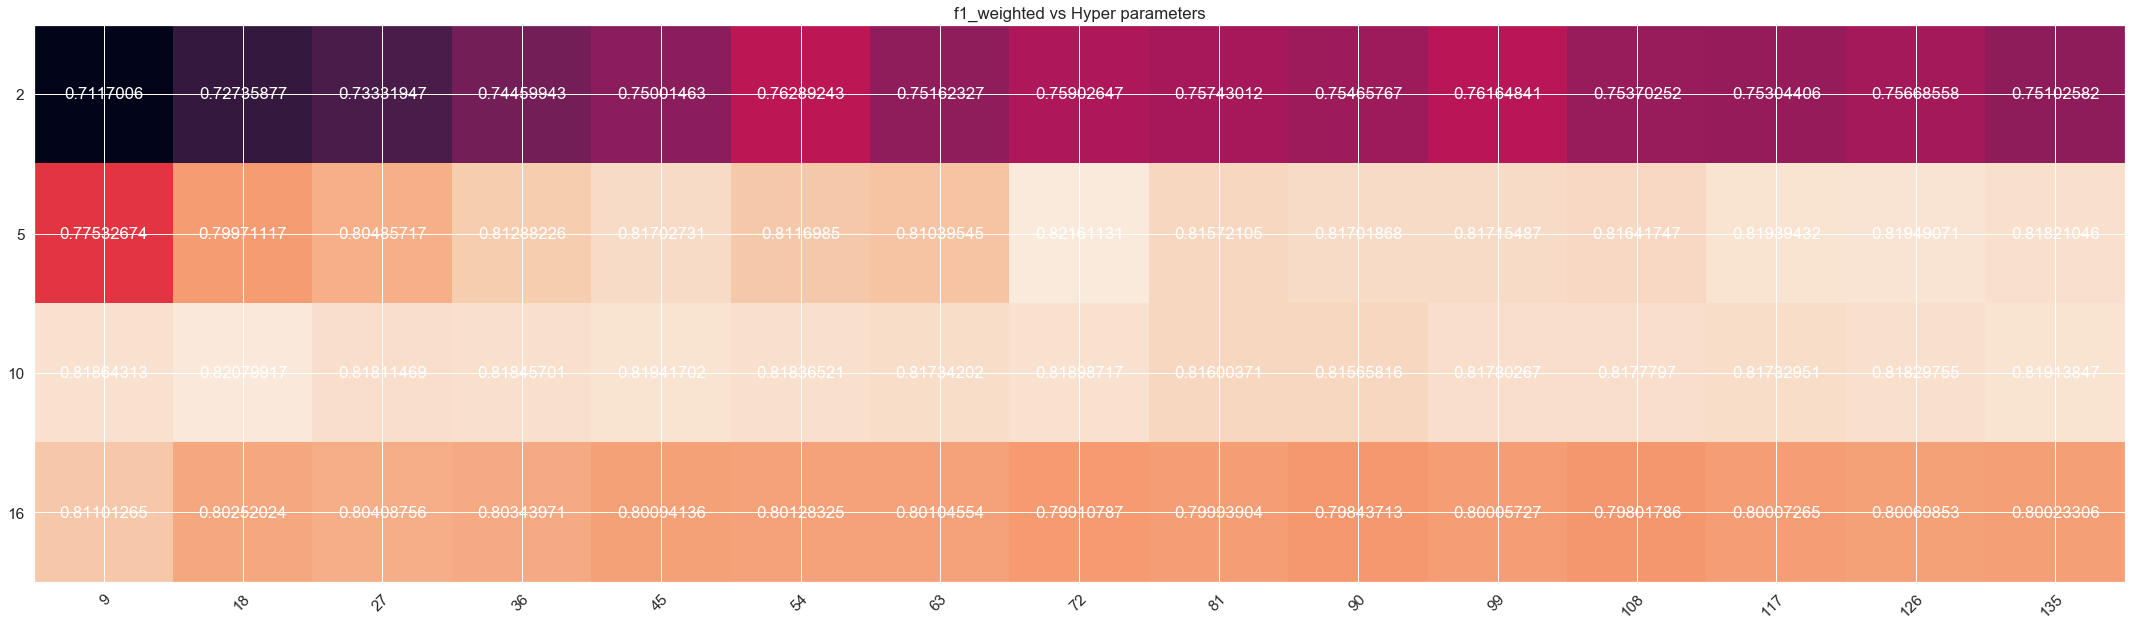

In [43]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

n_estimators=list(range(9, 136, 9))
max_depth=[2,5,10,16]

score_dict = np.array([[0.7117006 , 0.72735877, 0.73331947, 0.74459943, 0.75001463,
       0.76289243, 0.75162327, 0.75902647, 0.75743012, 0.75465767,
       0.76164841, 0.75370252, 0.75304406, 0.75668558, 0.75102582],
       [0.77532674, 0.79971117, 0.80485717, 0.81288226, 0.81702731,
       0.8116985 , 0.81039545, 0.82161131, 0.81572105, 0.81701868,
       0.81715487, 0.81641747, 0.81939432, 0.81949071, 0.81821046],
       [0.81864313, 0.82079917, 0.81811469, 0.81845701, 0.81941702,
       0.81836521, 0.81734202, 0.81898717, 0.81600371, 0.81565816,
       0.81780267, 0.8177797 , 0.81732951, 0.81829755, 0.81913847],
       [0.81101265, 0.80252024, 0.80408756, 0.80343971, 0.80094136,
       0.80128325, 0.80104554, 0.79910787, 0.79993904, 0.79843713,
       0.80005727, 0.79801786, 0.80007265, 0.80069853, 0.80023306]])

fig, ax = plt.subplots(figsize=(30,30))
im = ax.imshow(score_dict)

# We want to show all ticks...
ax.set_xticks(np.arange(len(n_estimators)))
ax.set_yticks(np.arange(len(max_depth)))
# ... and label them with the respective list entries
ax.set_xticklabels(n_estimators)
ax.set_yticklabels(max_depth)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(max_depth)):
    for j in range(len(n_estimators)):
        text = ax.text(j, i, score_dict[i, j],
                       ha="center", va="center", color="w")

ax.set_title("f1_weighted vs Hyper parameters")
fig.tight_layout()
plt.show()

# GridSearchCV for Gradient Boosted Decision Trees

In [50]:
#alogo = xgb.XGBClassifier(class_weight='balanced',min_samples_split=300,min_samples_leaf=30)
#params we need to try on classifier
#param_grid = {'n_estimators':range(1200,1501,100),'max_depth':[2,5,10,16]} 
#gsv_gbdt = GridSearchCV(alogo,param_grid,cv=timesplit,verbose=1,n_jobs=-1,scoring='f1_weighted')
alogo = xgb.XGBClassifier(class_weight='balanced',min_samples_split=300,min_samples_leaf=30)
#params we need to try on classifier
param_grid = {'n_estimators':range(50,121,10),'learning_rate': list(np.arange(0.05,0.2,0.05)),'max_depth':range(5,16,2)} 
gsv_gbdt = GridSearchCV(alogo,param_grid,cv=timesplit,verbose=1,n_jobs=-1,scoring='f1_weighted')
#alogo = xgb.XGBClassifier(class_weight="balanced")
#params we need to try on classifier
#param_grid = {'max_depth':[2,5,10,16],"n_estimators":[int(i) for i in range(10, 150, 20)]} 
#gsv_gbdt = GridSearchCV(alogo,param_grid,cv=timesplit,verbose=1,n_jobs=-1,scoring='f1')
gsv_gbdt.fit(train_tfidf_sent_vectors,y_train)
#export(gsv,"gsv_bigram")
print("Best HyperParameter: ",gsv_gbdt.best_params_)
print("Best Accuracy: %.2f%%"%(gsv_gbdt.best_score_*100))

Fitting 2 folds for each of 192 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 76.9min
[Parallel(n_jobs=-1)]: Done 384 out of 384 | elapsed: 146.1min finished


Best HyperParameter:  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 90}
Best Accuracy: 82.27%


D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy on test data set: 85.967%
Precision on test data set: 0.871
Recall on test data set: 0.978
F1-Score on test data set: 0.921
Confusion Matrix of test data set:
 [ [TN  FP]
 [FN TP] ]

Wall time: 164 ms


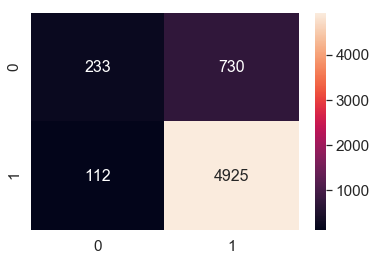

In [51]:
%%time
import seaborn as sns
alogo = gsv_gbdt.best_estimator_
y_pred = alogo.predict(test_tfidf_sent_vectors)
print("Accuracy on test data set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test data set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test data set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test data set: %0.3f"%(f1_score(y_test, y_pred)))
#print("Non Zero weights:",np.count_nonzero(alogo.coef_))
print("Confusion Matrix of test data set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

# Performance Table

In [52]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model","hyper parameter/Depth", "Train f1_weighted","Test Accuracy","F1-Score"]

x.add_row(["BOW_RF","n_estimators=136,max_depth=16", "87.82%","85.947%" ,0.913])
x.add_row(["BOW_GBDT","learning_rate=0.2,max_depth=7,n_estimators=90", "87.76%","86.65%" ,0.932])
x.add_row(["TFIDF_RF", "max_depth=16, n_estimators=135", "88.09%" , "86.197%",0.915])
x.add_row(["TFIDF_GBDT", "learning_rate=0.2,max_depth=11,n_estimators=110", "86.68%" , "87.567%",0.925])
x.add_row(["Avgw2v_RF", "max_depth=10,n_estimators=135", "84.49%" , "82.977%",0.929])
x.add_row(["Avgw2v_GBDT","learning_rate=0.2,max_depth=5,n_estimators=110", "84.37%" , "87.567%",0.929])
x.add_row(["Tfidf-w2v_RF","max_depth=5,n_estimators=7", "82.16%" , "76.983%",0.854])
x.add_row(["Tfidf-w2v_GBDT","learning_rate=0.2,max_depth=5,n_estimators=90", "82.27%" , "85.967%",0.921])



print(x)

+----------------+-------------------------------------------------+-------------------+---------------+----------+
|     Model      |              hyper parameter/Depth              | Train f1_weighted | Test Accuracy | F1-Score |
+----------------+-------------------------------------------------+-------------------+---------------+----------+
|     BOW_RF     |          n_estimators=136,max_depth=16          |       87.82%      |    85.947%    |  0.913   |
|    BOW_GBDT    |  learning_rate=0.2,max_depth=7,n_estimators=90  |       87.76%      |     86.65%    |  0.932   |
|    TFIDF_RF    |          max_depth=16, n_estimators=135         |       88.09%      |    86.197%    |  0.915   |
|   TFIDF_GBDT   | learning_rate=0.2,max_depth=11,n_estimators=110 |       86.68%      |    87.567%    |  0.925   |
|   Avgw2v_RF    |          max_depth=10,n_estimators=135          |       84.49%      |    82.977%    |  0.929   |
|  Avgw2v_GBDT   |  learning_rate=0.2,max_depth=5,n_estimators=110 |    

# Conclusion

1. From all the vectorization BOW is giving best result in GBDT .

2. The accuray of GBDT and random forest is lower than liner model , it is because separation at high dimensional space using hyperplanes is easier than doing a decision tree based approach.

3. GBDT consistently performs better than RF for Amazon review classiciation problem but it is biased towards higher class level . As gbdt contains lots of hyperparameter need to be tune very carefully .

4. Class_weight is playing vital role in both the classification , or else it is giving very weried result.

5. We try so many scoring technique for finding the best hyperparmeter , but f1_weighted  is giving the best result in terms of scoring technique .

6. Words like  "dissapoint", "horrible","love", "good", "best" have high feature importance, as evident from the wordcloud

7. For text classification rf and gbdt is not good alogorithm like linear model.